# Create figure with overview of the data

### Required data to make the figure:
- T cell count timeseries
- Timeseries of canonical TRM subsets
- flow cytometry data
- mouse and lung cartoon
- selected markers used for the analyses

In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pickle
import json
import numpy as np
import pandas as pd
import scipy.stats as sts
from scipy.special import logit, expit
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)

import scdynsys.plots as plots
from scdynsys.splines import fit_smoothing_spline


tex_fonts = {
    "font.family" : "Helvetica",
    'pdf.fonttype' : 42,
}

plt.rcParams.update(tex_fonts)


spline_color = 'k'
spline_lw = 0.7
spline_dash = (0, (10,10))
show_excluded_data = False # show gray dots
default_spline_kwargs = {
    "linewidth" : spline_lw, "color" : spline_color, "zorder" : 1
}

labx, laby = -0.1, 1.07

In [2]:
cellcount_file_CD8 = "../data/CD8_counts_Aug23.pkl"
cellcount_file_CD4 = "../data/CD4_counts_Aug23.pkl"

with open(cellcount_file_CD8, 'rb') as f:
    cell_counts_CD8 = pickle.load(f)
    
with open(cellcount_file_CD4, 'rb') as f:
    cell_counts_CD4 = pickle.load(f)

marker_data_file_CD8 = "../data/parsed_flow_data_Lung_CD8_ivneg_agexp_exptAug23.csv"
marker_data_file_CD4 = "../data/parsed_flow_data_Lung_CD4_conv_ivneg_agexp_exptAug23.csv"
    
marker_data_CD8 = pd.read_csv(marker_data_file_CD8, index_col=None)
marker_data_CD4 = pd.read_csv(marker_data_file_CD4, index_col=None)

In [3]:
fig = plt.figure(figsize=(14,13))
gs = GridSpec(16, 12+1) ## add some extra space as a separator

fig.subplots_adjust(wspace=1.3, hspace=0.5)

<Figure size 1400x1300 with 0 Axes>

### Cartoon of TRM timeseries experiment

* Show how mice are infected at different time points and than sacked on the same day
* Highlight I.V. labeling right before sacking
* Obligatory mouse and lung cartoons

In [4]:
## import mouse cartoon

mouse_im = plt.imread('../resources/mouse_cartoon.png')
lungs_im = plt.imread('../resources/lungs_cartoon.png')

imagebox_mouse1 = OffsetImage(mouse_im, zoom = 0.05)
imagebox_lungs1 = OffsetImage(lungs_im, zoom = 0.025)

## Panel with experimental setup

ax = fig.add_subplot(gs[0:4,0:4])

dpis = cell_counts_CD8["DPI"]

udpis = sorted(np.unique(dpis))

pos = -np.arange(len(udpis))

for y, t in zip(pos, udpis):
    ax.plot([-t, 0], [y, y], color='k')
    ax.scatter([-t, 0], [y, y], color='k')

annbox_mouse1 = AnnotationBbox(imagebox_mouse1, (0.0, 0.6), frameon=False, xycoords='axes fraction')
ax.add_artist(annbox_mouse1)

annbox_lungs1 = AnnotationBbox(imagebox_lungs1, (1.1, 0.6), frameon=False, xycoords='axes fraction')
ax.add_artist(annbox_lungs1)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.left.set_visible(False)

props = dict(boxstyle='round', facecolor='w')

ax.axvline(x=-1, color='k', lw=1)
xcoord_iv = -2
ax.text(xcoord_iv, 1, "i.v.\nlabeling", color='k', ha='right', va='bottom', bbox=props)

ax.axvline(x=0, color='k', lw=1)
ax.text(1, 1, "sample\nlung tissue", color='k', ha='left', va='bottom', bbox=props)

xcoord_infection = -40

ax.text(xcoord_infection, 1, "intranasal\nIAV infection", ha='center', va='bottom', bbox=props)

conn_idxs = [3, 7, 9]
conn_styles = [
    "angle3,angleA=-90,angleB=0",
    "angle3,angleA=-90,angleB=-45",
    "angle3,angleA=-90,angleB=45",
]

aps = dict(
    facecolor='black', 
    arrowstyle='->',
    lw=1,
    shrinkB=10
)

for cn , i in zip(conn_styles, conn_idxs):
    aps["connectionstyle"] = cn
    ax.annotate(
        '', xy=(-udpis[i], pos[i]), transform=ax.transData,
        xytext=(xcoord_infection, 0.5), va='bottom', ha='center',
        arrowprops=aps
    )


# draw arrow for i.v. labeling

aps["connectionstyle"] = "angle3,angleA=-90,angleB=0"
aps["shrinkB"] = 5

ax.annotate('', xy=(0, -0.5), xytext=(-7, 0.5), 
    transform=ax.transData, va='bottom', ha='center',
    arrowprops=aps
)

# draw arrow for sacking

aps["connectionstyle"] = "angle3,angleA=-90,angleB=200"
aps["shrinkB"] = 10

ax.annotate('', xy=(0, -2), xytext=(7, 0.5), 
    transform=ax.transData, va='bottom', ha='center',
    arrowprops=aps
)


ymin = ax.transAxes.inverted().transform(ax.transData.transform((-40,-0.1)))[1]
ax.set_yticks([])

ax.set_xlabel("days prior to sampling")

ax.set_xticks(-np.array(udpis))
ax.set_xticklabels(udpis)

ax.text(labx, laby, 'A', fontsize='xx-large', transform=ax.transAxes)

Text(-0.1, 1.07, 'A')

### Panel with cell counts

Plot timeseries of CD8 and CD4 cell counts. These are I.V. protected, antigen experienced T cells.

In [5]:
def plot_total(
    ax_total, cell_counts, parent_key, lineage, 
    label=None, spline_kwargs=None, stripped=False
):
    if spline_kwargs is None:
        spline_kwargs = default_spline_kwargs
    ax_total.set_yscale('log')
        
    ts, ns, include = cell_counts["DPI"], cell_counts[parent_key], cell_counts["include"]

    # remove zeros for log transform
    include = include & (ns > 0)
    
    xs, ys = ts[include], np.log(ns[include])
    
    spl, x_grid, y_smooth, bootstrap_spls, y_smooth_lower, y_smooth_upper = fit_smoothing_spline(xs, ys, bootstrap=200)
    
    incl_colors = ['k' if incl else '0.7' for incl in include]
    if not stripped:
        if show_excluded_data:
            ax_total.scatter(ts, ns, color=incl_colors, s=10, zorder=2)
        else:
            ax_total.scatter(ts[include], ns[include], color='k', s=10, zorder=2)
        ax_total.plot(x_grid, np.exp(y_smooth_lower), **spline_kwargs, linestyle=spline_dash)
        ax_total.plot(x_grid, np.exp(y_smooth_upper), **spline_kwargs, linestyle=spline_dash)
    ax_total.plot(x_grid, np.exp(y_smooth), **spline_kwargs)

    if label is not None:
        ax_total.text(labx, laby, label, fontsize='xx-large', transform=ax_total.transAxes)
    
    ax_total.set_xlabel("DPI")
    ax_total.set_title(f"{lineage}+ CD44+ CD11a+ i.v. neg. T cells")
    
    ax_total.set_xticks(udpis)
    ax_total.set_xticklabels(udpis)
    
    return spl, bootstrap_spls


ax_total8 = fig.add_subplot(gs[0:4,5:9])
ax_total4 = fig.add_subplot(gs[0:4,9:13], sharey=ax_total8)

parent_key_CD8 = "CD44+CD11a+_CD8"
parent_key_CD4 = "CD44+CD11a+_CD4_Tconv"

spl_CD8, bootstrap_spl_CD8 = plot_total(
    ax_total8, cell_counts_CD8, parent_key_CD8, "CD8", "B"
)

spl_CD4, bootstrap_spl_CD4 = plot_total(
    ax_total4, cell_counts_CD4, parent_key_CD4, "CD4", "C"
)

ax_total8.set_ylabel("number of cells")


Text(0, 0.5, 'number of cells')

### Get some estimates of the decay of antigen experienced cells

We can get these by taking the derivative of the fitted splines.
The bootstraps provide 95% CIs.

In [6]:
def compute_slopes_for_counts(spl, bootstrap_spls, t_probe=None):
    if t_probe is None:
        t_probe = [6, 16, 37]
    dspl = spl.derivative()
    dspls_bootstrap = [b_spl.derivative() for b_spl in bootstrap_spls]
    for t in t_probe:
        dydts = [db_spl(t) for db_spl in dspls_bootstrap]
        CI = np.percentile(dydts, q=[2.5, 97.5])
        # rate
        print(f"rate at time {t}: {dspl(t):0.2f} 95% CI: [{CI[0]:0.2f}, {CI[1]:0.2f}]")
        # doubling time
        t2s = np.log(2) / dspl(t), np.log(2) / CI[0], np.log(2) / CI[1]
        print(f"doubling time at time {t}: {t2s[0]:0.2f} 95% CI: [{t2s[1]:0.2f}, {t2s[2]:0.2f}]")


print("------------- slopes CD8 --------------")
compute_slopes_for_counts(spl_CD8, bootstrap_spl_CD8)

print("------------- slopes CD4 --------------")
compute_slopes_for_counts(spl_CD4, bootstrap_spl_CD4)

------------- slopes CD8 --------------
rate at time 6: 0.71 95% CI: [0.48, 0.78]
doubling time at time 6: 0.98 95% CI: [1.43, 0.89]
rate at time 16: -0.22 95% CI: [-0.36, -0.14]
doubling time at time 16: -3.18 95% CI: [-1.92, -5.01]
rate at time 37: -0.06 95% CI: [-0.16, 0.03]
doubling time at time 37: -12.27 95% CI: [-4.24, 22.33]
------------- slopes CD4 --------------
rate at time 6: 0.57 95% CI: [0.38, 0.63]
doubling time at time 6: 1.22 95% CI: [1.80, 1.10]
rate at time 16: -0.09 95% CI: [-0.19, 0.01]
doubling time at time 16: -7.58 95% CI: [-3.65, 137.51]
rate at time 37: -0.01 95% CI: [-0.10, 0.07]
doubling time at time 37: -61.59 95% CI: [-6.93, 9.59]


In [7]:
## Import TRM freqs

with open("../data/canonical-timeseries-Aug23-CD8.pkl", 'rb') as f:
    canonical_timeseries_CD8 = pickle.load(f)

with open("../data/canonical-timeseries-Aug23-CD4.pkl", 'rb') as f:
    canonical_timeseries_CD4 = pickle.load(f)
    
ts = canonical_timeseries_CD8["DPI"]
ys1 = canonical_timeseries_CD8['CD69+CD103+']
ys2 = canonical_timeseries_CD8['CD69+CD103-']

zs1 = canonical_timeseries_CD4['CD69+CXCR6+']
zs2 = canonical_timeseries_CD4['CD69+CXCR6-']

In [8]:
## get rates for TRM populations

def compute_slopes_for_freqs(ys, cell_counts, parent_key):
    ts, ns, include = cell_counts["DPI"], cell_counts[parent_key], cell_counts["include"]
    
    t_probe = [12]
    
    # fit a spline
    xs, ys = ts[include], np.log(ys[include] * ns[include])
    spl, x_grid, y_smooth, bootstrap_spls, y_smooth_lower, y_smooth_upper = fit_smoothing_spline(xs, ys, bootstrap=200)
    
    dspl = spl.derivative()
    dspls_bootstrap = [b_spl.derivative() for b_spl in bootstrap_spls]
    for t in t_probe:
        dydts = [db_spl(t) for db_spl in dspls_bootstrap]
        CI = np.percentile(dydts, q=[2.5, 97.5])
        # rate
        print(f"rate at time {t}: {dspl(t):0.2f} 95% CI: [{CI[0]:0.2f}, {CI[1]:0.2f}]")
        # doubling time
        t2s = np.log(2) / dspl(t), np.log(2) / CI[0], np.log(2) / CI[1]
        print(f"doubling time at time {t}: {t2s[0]:0.2f} 95% CI: [{t2s[1]:0.2f}, {t2s[2]:0.2f}]")


print("------------------- population y1 ----------------------")
compute_slopes_for_freqs(ys1, cell_counts_CD8, parent_key_CD8)

print("------------------- population y2 ----------------------")
compute_slopes_for_freqs(ys2, cell_counts_CD8, parent_key_CD8)

print("------------------- population z1 ----------------------")
compute_slopes_for_freqs(zs1, cell_counts_CD4, parent_key_CD4)

print("------------------- population z2 ----------------------")
compute_slopes_for_freqs(zs2, cell_counts_CD4, parent_key_CD4)


------------------- population y1 ----------------------
rate at time 12: -0.04 95% CI: [-0.14, 0.11]
doubling time at time 12: -16.67 95% CI: [-4.94, 6.32]
------------------- population y2 ----------------------
rate at time 12: -0.43 95% CI: [-0.54, -0.27]
doubling time at time 12: -1.60 95% CI: [-1.28, -2.60]
------------------- population z1 ----------------------
rate at time 12: -0.10 95% CI: [-0.15, 0.05]
doubling time at time 12: -7.20 95% CI: [-4.54, 13.99]
------------------- population z2 ----------------------
rate at time 12: -0.02 95% CI: [-0.18, 0.11]
doubling time at time 12: -28.47 95% CI: [-3.94, 6.17]


In [9]:
## panel with canonical TRM frequencies

def plot_subpop_freq(ax, ys, title, label, cell_counts):
    ts, include = cell_counts["DPI"], cell_counts["include"]
    incl_colors = ['k' if incl else '0.7' for incl in include]

    if show_excluded_data:
        ax.scatter(ts, ys, color=incl_colors, s=10, zorder=2)
    else:
        ax.scatter(ts[include], ys[include], color='k', s=10, zorder=2)
    ax.set_title(title)
    ax.set_xlabel("DPI")
    
    # fit a spline
    xs, ys = ts[include], ys[include]
    spl, x_grid, y_smooth, bootstrap_spls, y_smooth_lower, y_smooth_upper = fit_smoothing_spline(xs, ys, bootstrap=200)
    ax.plot(x_grid, y_smooth, **default_spline_kwargs)
    ax.plot(x_grid, y_smooth_lower, **default_spline_kwargs, linestyle=spline_dash)
    ax.plot(x_grid, y_smooth_upper, **default_spline_kwargs, linestyle=spline_dash)
    
    ax.text(labx, laby, label, fontsize='xx-large', transform=ax.transAxes)


ax = fig.add_subplot(gs[5:8,0:3])
bx = fig.add_subplot(gs[5:8,3:6], sharex=ax, sharey=ax)

cx = fig.add_subplot(gs[5:8,7:10], sharex=ax)
dx = fig.add_subplot(gs[5:8,10:13], sharex=ax, sharey=cx)


plot_subpop_freq(ax, ys1, "CD8+ CD69+ CD103+", "D", cell_counts_CD8)
plot_subpop_freq(bx, ys2, "CD8+ CD69+ CD103-", "E", cell_counts_CD8)

plot_subpop_freq(cx, zs1, "CD4+ CD69+ CXCR6+", "F", cell_counts_CD4)
plot_subpop_freq(dx, zs2, "CD4+ CD69+ CXCR6-", "G", cell_counts_CD4)

for xx in [ax, cx]:
    xx.set_ylabel("fraction of i.v. protected")

sparse_udpis = [str(d) if d not in [8, 16, 24] else "" for d in udpis]

for xx in [ax, bx, cx, dx]:
    xx.set_xticks(udpis)
    xx.set_xticklabels(sparse_udpis)

### Marginal densities of markers

Make a panel with the marginal densities (1D FACS plots) of the selected T cell markers. The data is split per time points (but aggregated across mice from the same time point)

In [10]:
## compute marker data densities

def compute_marginals(marker_file, marker_data):
    with open(marker_file) as f:
        selected_markers = json.load(f)
    
    marginals = {
        m : [] for m in selected_markers
    }
    
    selected_days = udpis[2:] # FIXME: include 6DPI?
    
    for m in selected_markers:
        xs = marker_data.loc[:,m].to_numpy()
        xmin, xmax = np.percentile(xs, q=[0, 100])
        ys = np.linspace(xmin, xmax, 100)
        for d in selected_days:
            event_sel = (marker_data.dpi == d)
            xs_sel = xs[event_sel]
            zs = sts.gaussian_kde(xs_sel)(ys)
            marginals[m].append((ys, zs))

    return marginals, selected_markers, selected_days

marker_file_CD8 = "../data/selected-markers-CD8-Aug23.json"
marker_file_CD4 = "../data/selected-markers-CD4-conv-Aug23.json"

marginals_CD8 = compute_marginals(marker_file_CD8, marker_data_CD8)
marginals_CD4 = compute_marginals(marker_file_CD4, marker_data_CD4)

In [11]:
## panel with marginal densities of markers

def plot_marginals(ax, marginals, selected_markers, selected_days):
    num_markers = len(selected_markers)
    num_days = len(selected_days)
    
    xscale = 1/num_markers
    yscale = 1/num_days
    
    for i, m in enumerate(selected_markers):
        xoffset = i / num_markers
        ax.axvline(xoffset, color='k', lw=1)
        for j, d in enumerate(selected_days):
            yoffset = 1 - (j+1) / num_days
            if i == 0:
                ax.axhline(yoffset, color='k', lw=1)
            xs, zs = marginals[m][j]
            sxs = (xs - xs[0]) / (xs[-1] - xs[0])
            szs = 0.9 * zs / np.max(zs)
            txs, tzs = xoffset+sxs*xscale, yoffset+szs*yscale
            ax.plot(txs, tzs, color='k')
            ax.fill_between(txs, yoffset, tzs, color='0.8')
        
        ax.text(xoffset + xscale/2, 1, m, va='bottom', ha='center')    
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    yticks = np.linspace(0, 1, num_days+1)[:-1] + 0.5/num_days
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"{x} DPI" for x in reversed(selected_days)])
    
    ax.set_ylabel("density")
    ax.set_xlabel("fluorescence")


ax = fig.add_subplot(gs[9:16,0:6])
bx = fig.add_subplot(gs[9:16,7:13])

plot_marginals(ax, *marginals_CD8)
plot_marginals(bx, *marginals_CD4)

ax.set_title("CD8 lineage", y=1.05)
bx.set_title("CD4 lineage", y=1.05)


# label (add ax for proper alignment)
Ax = fig.add_subplot(gs[9:14,0:4])
Ax.axis('off')
Ax.text(labx, laby, 'H', fontsize='xx-large', transform=Ax.transAxes)

Bx = fig.add_subplot(gs[9:14,7:11])
Bx.axis('off')
Bx.text(labx, laby, 'I', fontsize='xx-large', transform=Bx.transAxes)

Text(-0.1, 1.07, 'I')

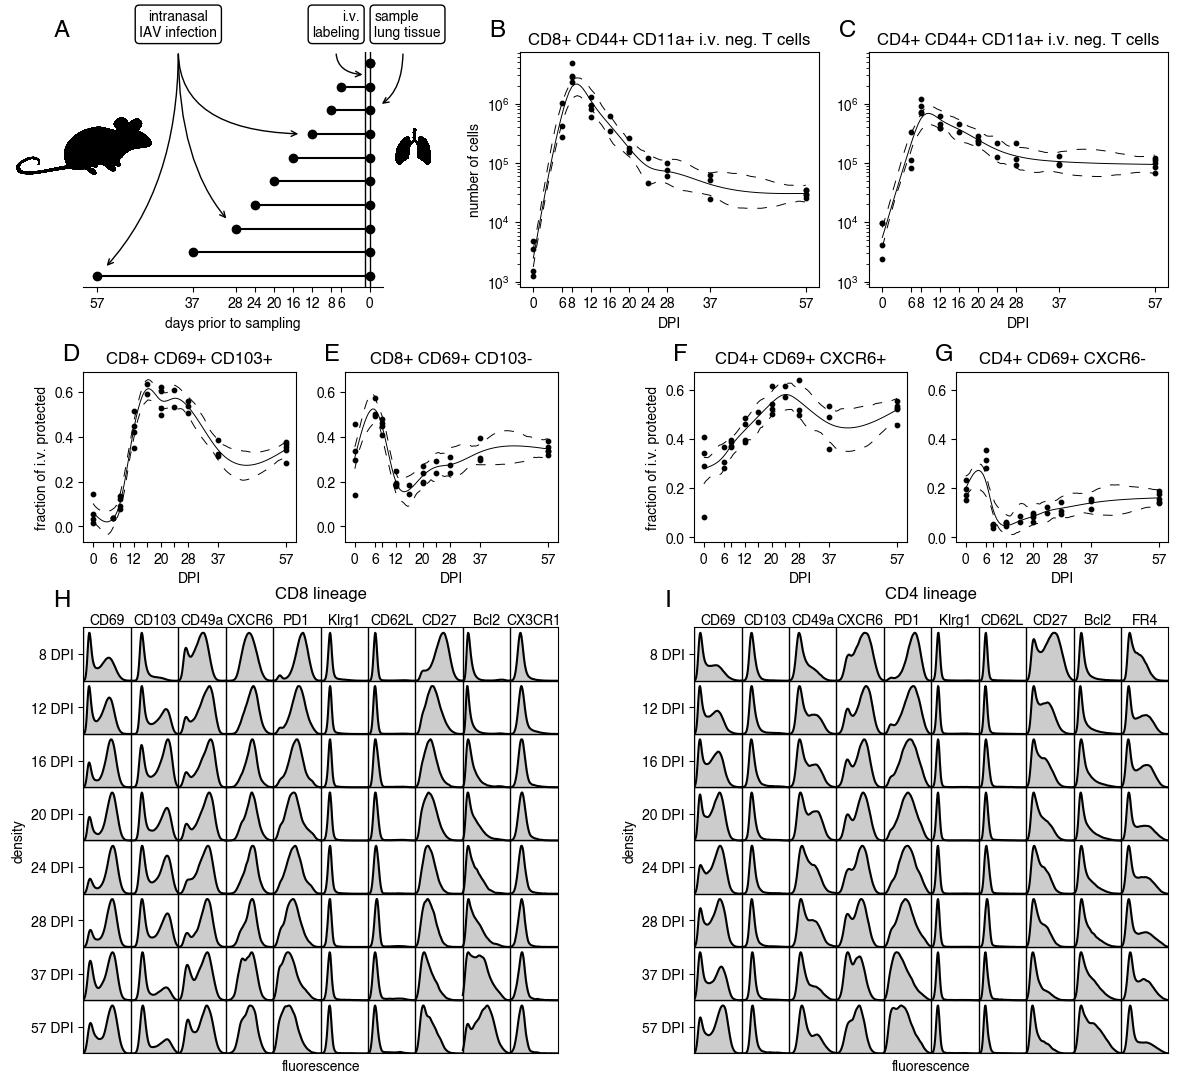

In [12]:
fig

In [13]:
#fig.savefig("../results/FigureDataOverview.pdf", bbox_inches='tight', dpi=300)

## Supplemental figures

Create supplemental figures accompanying the data figure in the main text. These figures show quality control (QC) and the global dynamic of Tetramer+ cells. 

* weight loss of mice
* I.V. labeling
* Tetramer-positive cell count

### Weight curves and I.V. label QC

In [14]:
gs = GridSpec(13, 6)

fig = plt.figure(figsize=(14, 12))

fig.subplots_adjust(wspace=0.6, hspace=0.3)

<Figure size 1400x1200 with 0 Axes>

In [15]:
# plot weight curves

with open("../data/weight_curves.pkl", 'rb') as f:
    weight_curves = pickle.load(f)
    
# unpack data
mouse_IDs = weight_curves["mouse_IDs"]
weight_data = weight_curves["weight_data"]
ear_number_map = weight_curves["ear_number_map"]
sampling_days = weight_curves["sampling_days"]

excluded_mice_weight = [7, 17, 19, 25, 32, 33]

weight_axs = {}
show_xticks = {}
ax = None # use i for loop for sharex and sharey
for i, d in enumerate(sampling_days):
    a, b = divmod(i, 3)
    ax = fig.add_subplot(gs[2*a:2*(a+1),2*b:2*(b+1)], sharex=ax, sharey=ax)
    weight_axs[d] = ax
    ax.text(0.95, 0.05, f"{d[1:]} DPI", transform=ax.transAxes, ha='right', va='bottom')
    show_xticks[d] = (a == 2) ## third row gets tick labels

for ID in mouse_IDs:
    d = ID.split("_")[0]
    incl = ear_number_map[ID] not in excluded_mice_weight
    color = 'k' if incl else 'r'
    ax = weight_axs[d]
    ts, xs = weight_data[ID]
    ax.plot([0] + ts, [100] + xs, color=color, linewidth=1, marker='o', markersize=2)
    # remove redundant xticklabels
    if not show_xticks[d]:
        plt.setp(ax.get_xticklabels(), visible=False)
    
    
# ylabel to center ax
ax = weight_axs["D16"]
ax.set_ylabel("percentage of weight at 0 DPI")

# xlabel to center ax
ax = weight_axs["D37"]
ax.set_xlabel("DPI")

Ax = fig.add_subplot(gs[0:4,0:3])
Ax.axis('off')
Ax.text(labx, laby, 'A', fontsize='xx-large', transform=Ax.transAxes)

Text(-0.1, 1.07, 'A')

### Plot IV labeling per time point and mouse

In [16]:
with open("../data/QC_IV_label.pkl", 'rb') as f:
    data_figureS1_iv = pickle.load(f)

iv_axs = {}
show_xticks = {}
ax = None # use i for loop for sharex and sharey
yo = 7
for i, d in enumerate(udpis[1:]): # skip 0 DPI
    a, b = divmod(i, 3)
    ax = fig.add_subplot(gs[2*a+yo:2*(a+1)+yo,2*b:2*(b+1)], sharex=ax, sharey=ax)
    iv_axs[d] = ax
    ax.text(0.95, 0.95, f"{d} DPI", transform=ax.transAxes, ha='right', va='top')
    show_xticks[d] = (a == 2) ## third row gets tick labels

excluded_mice_iv = [27, 35]

for ID in data_figureS1_iv.keys():
    incl = ID not in excluded_mice_iv
    color = 'k' if incl else 'r'
    ys = data_figureS1_iv[ID]["ys"]
    d = data_figureS1_iv[ID]["dpi"]
    ax = iv_axs[d]
    ts = np.linspace(-1, 5, 200)
    zs = sts.gaussian_kde(ys)(ts)
    ax.plot(ts, zs, color=color, linewidth=1)
    # remove redundant xticklabels
    if not show_xticks[d]:
        plt.setp(ax.get_xticklabels(), visible=False)

# ylabel to center ax
ax = iv_axs[16]
ax.set_ylabel("density")

# xlabel to center ax
ax = iv_axs[37]
ax.set_xlabel("CD45.2 IV")

Ax = fig.add_subplot(gs[7:11,0:3])
Ax.axis('off')
Ax.text(labx, laby, 'B', fontsize='xx-large', transform=Ax.transAxes)

Text(-0.1, 1.07, 'B')

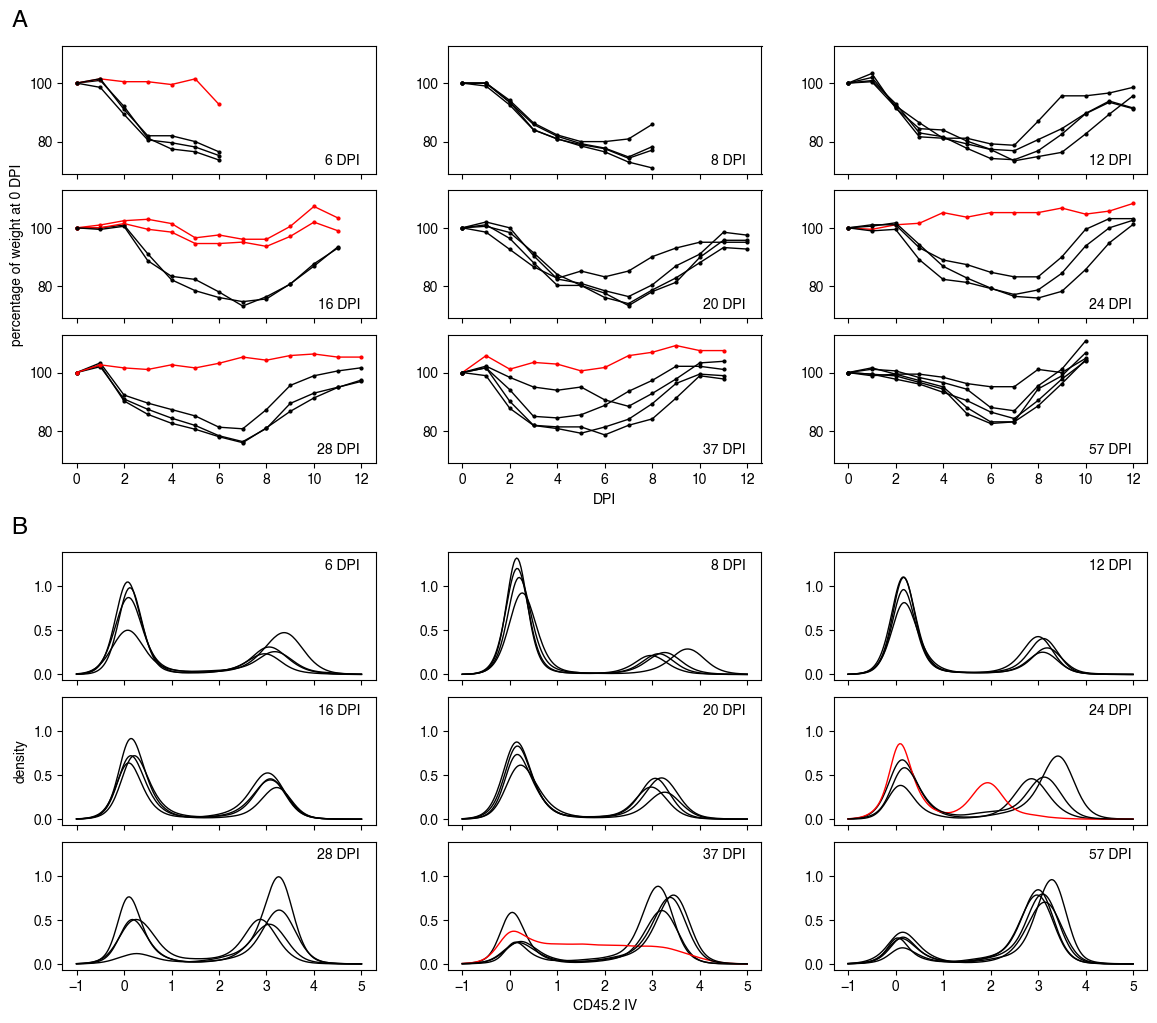

In [17]:
fig

In [18]:
#fig.savefig("../results/FigureWeights.pdf", bbox_inches='tight')

### Figure for tet+ cell counts

Show the number of Tet+ CD8 and CD4 T cells, together with the number of total CD8 and CD4 T cells (both I.V. protected and antigen experienced). Also compute the fraction of Tet+ cells

In [19]:
gs = GridSpec(9, 6)

fig = plt.figure(figsize=(14,9))

fig.subplots_adjust(wspace=0.6, hspace=0.3)

<Figure size 1400x900 with 0 Axes>

In [20]:
# plot tetramer positive CD8 T cells
spl_kwargs_stripped = dict(color='red', linewidth=0.7, label="bulk")

ax_total = fig.add_subplot(gs[0:4,0:3])
spl_tet8, bootstrap_spls_tet8 = plot_total(
    ax_total, cell_counts_CD8, 
    "tetpos_CD8", "CD8", 
    label="A"
)
plot_total(
    ax_total, cell_counts_CD8, "CD44+CD11a+_CD8", "CD8", 
    stripped=True, spline_kwargs=spl_kwargs_stripped
)
ax_total.set_xlabel("DPI")
ax_total.set_title("CD8+ Tet+ i.v. neg. T cells")
ax_total.set_ylabel("number of cells")
ax_total.legend()

# same for CD4 

ax_total = fig.add_subplot(gs[5:9,0:3])
spl_tet4, bootstrap_spls_tet4 = plot_total(
    ax_total, cell_counts_CD4, 
    "tetpos_CD4_Tconv", "CD4", 
    label="C"
)
plot_total(
    ax_total, cell_counts_CD4, "CD44+CD11a+_CD4_Tconv", "CD4", 
    stripped=True, spline_kwargs=spl_kwargs_stripped
)
ax_total.set_xlabel("DPI")
ax_total.set_title("CD4+ Tet+ i.v. neg. T cells")
ax_total.set_ylabel("number of cells")
ax_total.legend()

### get some estimates of the decay of tetramer positive cells

In [21]:
print("---------------- CD8 tet+ -----------------")
compute_slopes_for_counts(spl_tet8, bootstrap_spls_tet8)

print("---------------- CD4 tet+ -----------------")
compute_slopes_for_counts(spl_tet4, bootstrap_spls_tet4)

---------------- CD8 tet+ -----------------
rate at time 6: 1.19 95% CI: [0.77, 1.22]
doubling time at time 6: 0.58 95% CI: [0.90, 0.57]
rate at time 16: -0.23 95% CI: [-0.41, -0.13]
doubling time at time 16: -3.00 95% CI: [-1.69, -5.24]
rate at time 37: -0.05 95% CI: [-0.17, 0.11]
doubling time at time 37: -15.14 95% CI: [-4.18, 6.35]
---------------- CD4 tet+ -----------------
rate at time 6: 0.90 95% CI: [0.55, 0.94]
doubling time at time 6: 0.77 95% CI: [1.26, 0.74]
rate at time 16: -0.16 95% CI: [-0.31, -0.05]
doubling time at time 16: -4.35 95% CI: [-2.27, -13.36]
rate at time 37: -0.05 95% CI: [-0.20, 0.06]
doubling time at time 37: -13.71 95% CI: [-3.53, 11.00]


### Plot fraction of tetramer positive CD8 T cells

In [22]:
def plot_tetpos_fraction(ax_frac, cell_counts, parent_key, subpop_key, lineage): 
    ts, ks, include = cell_counts["DPI"], cell_counts[subpop_key], cell_counts["include"]
    ns = cell_counts[parent_key]
    
    xs, ys = ts[include], ks[include] / ns[include]
    
    spl, x_grid, y_smooth, bootstrap_spls, y_smooth_lower, y_smooth_upper = \
        fit_smoothing_spline(xs, logit(ys+0.001), bootstrap=200, lam=100)
    
    incl_colors = ['k' if incl else '0.7' for incl in include]
    if show_excluded_data:
        ax_frac.scatter(ts, ks / ns, color=incl_colors, s=10, zorder=2)
    else:
        ax_frac.scatter(ts[include], ks[include] / ns[include], color='k', s=10, zorder=2)
    ax_frac.plot(x_grid, expit(y_smooth), **default_spline_kwargs)
    ax_frac.plot(x_grid, expit(y_smooth_lower), **default_spline_kwargs, linestyle=spline_dash)
    ax_frac.plot(x_grid, expit(y_smooth_upper), **default_spline_kwargs, linestyle=spline_dash)
    
    
    ax_frac.set_xlabel("DPI")
    ax_frac.set_title(f"Tet+ fraction of bulk {lineage}+ cells")
    ax_frac.set_ylabel("fraction of cells")
    
    ax_frac.set_xticks(udpis)
    ax_frac.set_xticklabels(udpis)

## CD8

ax_frac = fig.add_subplot(gs[0:4,3:6])
plot_tetpos_fraction(
    ax_frac, cell_counts_CD8, "CD44+CD11a+_CD8", "tetpos_CD8", "CD8"
)
ax_frac.text(labx, laby, 'B', fontsize='xx-large', transform=ax_frac.transAxes)

## CD4

ax_frac = fig.add_subplot(gs[5:9,3:6])
plot_tetpos_fraction(
    ax_frac, cell_counts_CD4, "CD44+CD11a+_CD4_Tconv", "tetpos_CD4_Tconv", "CD4"
)
ax_frac.text(labx, laby, 'D', fontsize='xx-large', transform=ax_frac.transAxes)


Text(-0.1, 1.07, 'D')

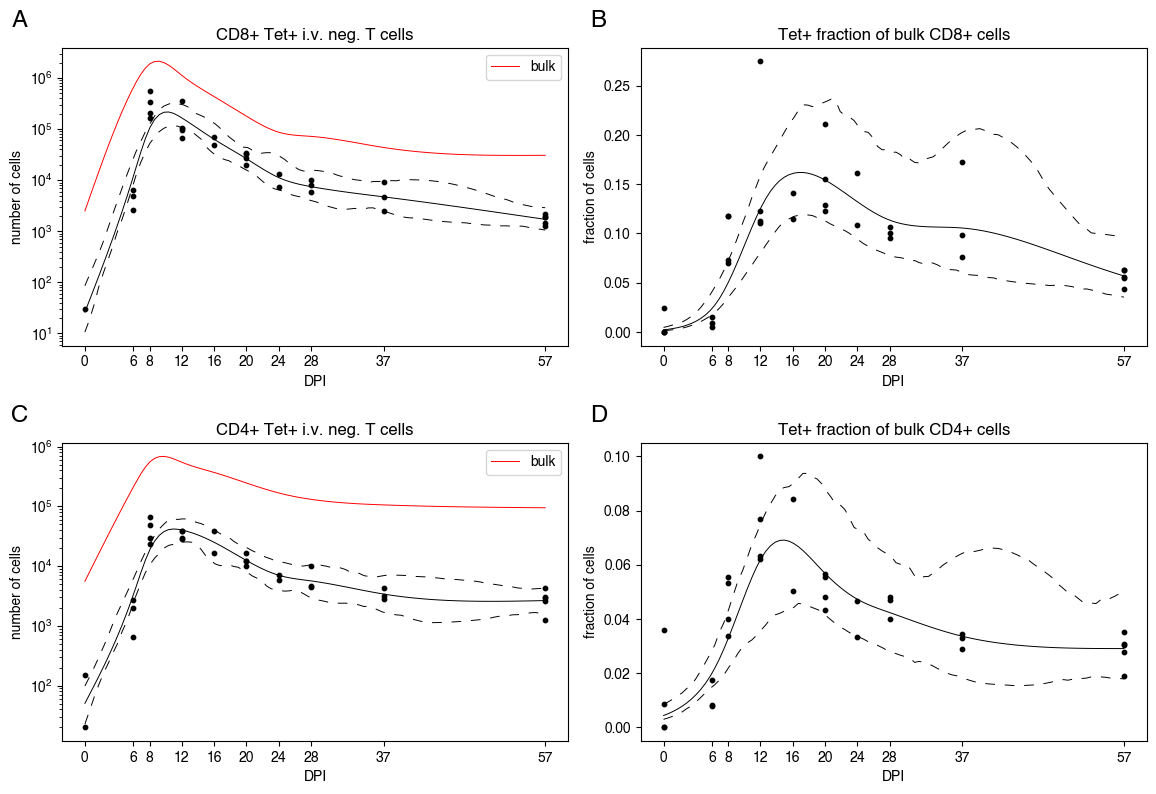

In [23]:
fig

In [24]:
#fig.savefig("../results/FigureTetPosCounts.pdf", bbox_inches='tight')